ils en ont 92 features pour entraîner groupe 52

## Setup

In [113]:

# Import libraries for data manipulation
import pandas as pd
from summarytools import dfSummary

import numpy as np

from icecream import ic
#ic(my_var) : fait un joli print direct

from ydata_profiling import ProfileReport

# import latexify

# Import libraries for data visualization
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

plt.style.use('seaborn-v0_8-whitegrid')

import seaborn as sns

import copy as cp

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from statsmodels.graphics.gofplots import ProbPlot

# Import libraries for building linear regression model
from statsmodels.formula.api import ols

# Import the required function
from scipy.stats import pearsonr

from sklearn.preprocessing import OrdinalEncoder


import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

# Import library for preparing data
from sklearn.model_selection import train_test_split

# Import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

## R2
from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")


####################
# Fonctions : 



def corr_plot(df, upper_tri=None, threshold=None):
    
    plt.figure(figsize = (12, 8))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)

    corr = df.corr()
    mask = None

    if threshold != None:
        corr = corr.mask(np.abs(corr) < threshold, np.nan)

    if upper_tri:
        mask = np.tril(np.ones_like(corr, dtype=bool)) # affichera que le triangle supérieur

    sns.heatmap(corr, mask=mask, annot = True, fmt = '.2f', cmap = cmap)
    plt.show()

    return corr

# RMSE
# @latexify.function
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAPE
# @latexify.function
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# MAE
# @latexify.function
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# Function to check VIF (TOUTES LES FEATURES DOIVENT ETRE EN FLOAT !!)
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


In [2]:
df = pd.read_csv("./data/X_train_Hi5.csv")
df = df.sample(n=10_000, random_state=42)
df.head()

,row_index,piezo_station_department_code,piezo_station_update_date,piezo_station_investigation_depth,piezo_station_department_name,piezo_station_commune_code_insee,piezo_station_pe_label,piezo_station_bdlisa_codes,piezo_station_altitude,piezo_station_bss_code,...,prelev_longitude_2,prelev_latitude_2,prelev_commune_code_insee_2,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_med_living_level,insee_%_ind,insee_%_const,piezo_groundwater_level_category
2613083,3067028,33,Fri Jun 28 07:31:38 CEST 2024,123.0,Gironde,33517,LE PORT (SOUSSANS-33),['334AG04'],3.59,07795X0106/PZEM9,...,NaN,NaN,NaN,NaN,19,1692.0,23100,6.3,18.5,Average
1268326,1334103,49,Fri Jan 12 10:28:05 CET 2024,93.5,Maine-et-Loire,49194,FONTAINE-MILONJurassique,['139AP14'],40.00,04552X0111/PZ2,...,-0.281423,47.471283,49194.0,18620902.0,8.8,5815.0,23560,8.8,12.5,Average
234393,246594,27,Mon Sep 23 19:38:51 CEST 2024,12.0,Eure,27391,PUITS DE L'ANCIENNE GARE (MARCILLY-SUR-EURE),['121AS01'],75.00,01807X0051/S1,...,1.365070,48.713810,28404.0,29117529.0,1.3,1588.0,25340,16.6,15.9,High
1670802,1756732,44,Fri Jun 28 07:31:38 CEST 2024,8.0,Loire-Atlantique,44025,Forage de LA RIVIERE,['104AB01'],5.00,04503X0068/PZ2,...,-1.881925,47.275110,44045.0,8572341.0,1,4005.0,23620,18.6,19.8,Average
2804886,3267483,77,Thu Sep 19 14:26:45 CEST 2024,15.0,Seine-et-Marne,77341,PIÉZOMÈTRE DE NOYEN-SUR-SEINE (NOYEN-SUR-SEINE...,['928AC01'],57.50,02606X0112/G5,...,NaN,NaN,NaN,NaN,0,384.0,24270,0,8.3,Very Low


In [43]:
target = "piezo_groundwater_level_category"

## Preprocessing

In [68]:
# On tolère 19% de nan dans les colonnes
for proportion_nan_prct in [19]:
    new_df = cp.deepcopy(df)
    for col in new_df.columns:
        if new_df[col].isnull().sum() * 100 / len(df) > proportion_nan_prct:
            new_df.drop(col, axis=1, inplace=True)

# new_df.info()

# Gérer les duplicatas
new_df.drop_duplicates(inplace=True)

# Drop les features indépendantes qui sont ultra corrélées entre elles (id...)
features_to_drop = ["piezo_station_commune_code_insee",
                    "piezo_station_pe_label",
                    "piezo_station_bdlisa_codes",
                    "piezo_station_bss_code",
                    "piezo_station_commune_name",
                    "piezo_station_bss_id",
                    "piezo_bss_code",
                    "piezo_station_update_date",
                    "piezo_qualification",
                    "piezo_continuity_code",
                    "piezo_continuity_name",
                    "piezo_producer_name",
                    "piezo_measure_nature_name",
                    "meteo_name",
                    "hydro_station_code",
                    "hydro_method_code",
                    "hydro_method_label",
                    "insee_med_living_level",
                    "meteo_id",
                    "hydro_qualification_label",
                    "hydro_status_code",
                    "piezo_station_department_name"]

features = new_df.drop(features_to_drop, axis=1)
# features.info()

num_col_features =      ["piezo_station_investigation_depth", 
                        "piezo_station_altitude", 
                        "piezo_station_longitude", 
                        "piezo_station_latitude", 
                        "piezo_producer_code", 
                        "meteo_latitude", 
                        "meteo_longitude", 
                        "meteo_altitude", 
                        "meteo_rain_height", 
                        "meteo_temperature_min", 
                        "meteo_time_tn", 
                        "meteo_temperature_max", 
                        "meteo_time_tx", 
                        "meteo_temperature_avg", 
                        "meteo_temperature_avg_threshold",
                        "meteo_frost_duration", 
                        "meteo_amplitude_tn_tx", 
                        "meteo_temperature_avg_tntm", 
                        "meteo_evapotranspiration_grid", 
                        "distance_piezo_meteo", 
                        "hydro_observation_result_elab", 
                        "hydro_longitude",
                        "hydro_latitude", 
                        "distance_piezo_hydro", 
                        "prelev_other_volume_sum", 
                        "insee_%_agri", 
                        "insee_pop_commune", 
                        "insee_%_ind", 
                        "insee_%_const"]

cat_col_features = ["piezo_station_department_code",  
                    "piezo_obtention_mode", 
                    "piezo_status", 
                    "piezo_measure_nature_code", 
                    "hydro_status_label", 
                    "hydro_qualification_code",  
                    "hydro_hydro_quantity_elab"]


# On traite le dataframe features entier
new_features = cp.deepcopy(features)

new_features[num_col_features] = new_features[num_col_features].replace('N/A - division par 0', np.nan)
new_features[num_col_features] = new_features[num_col_features].replace('nan', np.nan)

for col in num_col_features:
    new_features[col].astype("float")

# imputation des valeurs numériques manquantes (np.nan) : 

imputer_mean_posterior = IterativeImputer(random_state=42, sample_posterior=True)

imputer_mean_posterior.fit(new_features[num_col_features])
values_imputed = imputer_mean_posterior.transform(new_features[num_col_features])

new_features[num_col_features] = values_imputed

# # vérif plus de nan en numérique
# nan_count = new_features[num_col_features].isna().sum()
# print(nan_count)
# total_nan_count = new_features[num_col_features].isna().sum().sum()
# print(total_nan_count)

# Gérer les 3 features datetime

new_features['DATE_piezo_measurement_date'] = pd.to_datetime(new_features['piezo_measurement_date'])

new_features['year_piezo_measurement'] = new_features['DATE_piezo_measurement_date'].dt.year
new_features['month_piezo_measurement'] = new_features['DATE_piezo_measurement_date'].dt.month
new_features['day_piezo_measurement'] = new_features['DATE_piezo_measurement_date'].dt.day
new_features = new_features.drop(['piezo_measurement_date'], axis=1)

new_features['DATE_meteo_date'] = pd.to_datetime(new_features['meteo_date'])

new_features['year_meteo_date'] = new_features['DATE_meteo_date'].dt.year
new_features['month_meteo_date'] = new_features['DATE_meteo_date'].dt.month
new_features['day_meteo_date'] = new_features['DATE_meteo_date'].dt.day
new_features = new_features.drop(['meteo_date'], axis=1)


new_features['DATE_hydro_observation_date_elab'] = pd.to_datetime(new_features['hydro_observation_date_elab'])

new_features['year_hydro_observation_date_elab'] = new_features['DATE_hydro_observation_date_elab'].dt.year
new_features['month_hydro_observation_date_elab'] = new_features['DATE_hydro_observation_date_elab'].dt.month
new_features['day_hydro_observation_date_elab'] = new_features['DATE_hydro_observation_date_elab'].dt.day
new_features = new_features.drop(['hydro_observation_date_elab'], axis=1)


new_features_2 = cp.deepcopy(new_features) # au cas où je fais un truc nul


# target_feature = new_features_2[target]

# Ordinal encoding :

ord_cols = ["piezo_obtention_mode", 
            "piezo_status", 
            "piezo_measure_nature_code", 
            "hydro_status_label",
            "hydro_qualification_code",
            "piezo_groundwater_level_category"]

for col in ord_cols:

    temp = new_features_2[col]
    temp = pd.DataFrame(temp)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(temp)
    ordinal_enc = ordinal_encoder.transform(temp)

    new_features_2['ORDINAL_' + col] = ordinal_enc


new_features_2 = new_features_2.drop(ord_cols, axis=1)

# test.sample(50)

# Onehot encoding
onehot_cols = ["piezo_station_department_code", "hydro_hydro_quantity_elab"]
new_features_2 = pd.get_dummies(new_features_2, columns=onehot_cols, drop_first=True)
# new_features_2[target] = target_feature # tout est onehot encodé sauf la target var

# Drop les colonnes avec "DATE" (datetime qui sert plus à rien) :

date_cols = ["DATE_piezo_measurement_date", "DATE_meteo_date", "DATE_hydro_observation_date_elab"]
new_features_2 = new_features_2.drop(date_cols, axis=1)


# On cast toutes les features (maintenant toutes encodées donc numérique ou booléen) 
# en float

for col in new_features_2.columns:
    new_features_2[col] = new_features_2[col].astype("float64")


In [55]:
pd.set_option('display.max_columns', None)
new_features_2.head()

,row_index,piezo_station_investigation_depth,piezo_station_altitude,piezo_station_longitude,piezo_station_latitude,piezo_producer_code,meteo_latitude,meteo_longitude,meteo_altitude,meteo_rain_height,meteo_temperature_min,meteo_time_tn,meteo_temperature_max,meteo_time_tx,meteo_temperature_avg,meteo_temperature_avg_threshold,meteo_frost_duration,meteo_amplitude_tn_tx,meteo_temperature_avg_tntm,meteo_evapotranspiration_grid,distance_piezo_meteo,hydro_observation_result_elab,hydro_longitude,hydro_latitude,distance_piezo_hydro,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_%_ind,insee_%_const,DATE_piezo_measurement_date,year_piezo_measurement,month_piezo_measurement,day_piezo_measurement,DATE_meteo_date,year_meteo_date,month_meteo_date,day_meteo_date,DATE_hydro_observation_date_elab,year_hydro_observation_date_elab,month_hydro_observation_date_elab,day_hydro_observation_date_elab,ORDINAL_piezo_obtention_mode,ORDINAL_piezo_status,ORDINAL_piezo_measure_nature_code,ORDINAL_hydro_status_label,ORDINAL_hydro_qualification_code,ORDINAL_piezo_groundwater_level_category,piezo_station_department_code_02,piezo_station_department_code_03,piezo_station_department_code_04,piezo_station_department_code_05,piezo_station_department_code_06,piezo_station_department_code_07,piezo_station_department_code_08,piezo_station_department_code_09,piezo_station_department_code_10,piezo_station_department_code_11,piezo_station_department_code_12,piezo_station_department_code_13,piezo_station_department_code_14,piezo_station_department_code_15,piezo_station_department_code_16,piezo_station_department_code_17,piezo_station_department_code_18,piezo_station_department_code_19,piezo_station_department_code_21,piezo_station_department_code_22,piezo_station_department_code_23,piezo_station_department_code_24,piezo_station_department_code_25,piezo_station_department_code_26,piezo_station_department_code_27,piezo_station_department_code_28,piezo_station_department_code_29,piezo_station_department_code_2A,piezo_station_department_code_2B,piezo_station_department_code_30,piezo_station_department_code_31,piezo_station_department_code_32,piezo_station_department_code_33,piezo_station_department_code_34,piezo_station_department_code_35,piezo_station_department_code_36,piezo_station_department_code_37,piezo_station_department_code_38,piezo_station_department_code_39,piezo_station_department_code_40,piezo_station_department_code_41,piezo_station_department_code_42,piezo_station_department_code_43,piezo_station_department_code_44,piezo_station_department_code_45,piezo_station_department_code_46,piezo_station_department_code_47,piezo_station_department_code_48,piezo_station_department_code_49,piezo_station_department_code_50,piezo_station_department_code_51,piezo_station_department_code_52,piezo_station_department_code_53,piezo_station_department_code_54,piezo_station_department_code_55,piezo_station_department_code_56,piezo_station_department_code_57,piezo_station_department_code_58,piezo_station_department_code_59,piezo_station_department_code_60,piezo_station_department_code_61,piezo_station_department_code_62,piezo_station_department_code_63,piezo_station_department_code_64,piezo_station_department_code_65,piezo_station_department_code_66,piezo_station_department_code_67,piezo_station_department_code_68,piezo_station_department_code_69,piezo_station_department_code_70,piezo_station_department_code_71,piezo_station_department_code_72,piezo_station_department_code_73,piezo_station_department_code_74,piezo_station_department_code_75,piezo_station_department_code_76,piezo_station_department_code_77,piezo_station_department_code_78,piezo_station_department_code_79,piezo_station_department_code_80,piezo_station_department_code_81,piezo_station_department_code_82,piezo_station_department_code_83,piezo_station_department_code_84,piezo_station_department_code_85,piezo_station_department_code_86,piezo_station_department_code_87,piezo_station_department_code_88,piezo_sta

In [70]:
new_features_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2613083 to 1625530
Columns: 139 entries, row_index to hydro_hydro_quantity_elab_QmM
dtypes: float64(139)
memory usage: 10.9 MB


### Suite preprocessing

#### Virer les nans et inf qu'il y a encore ?

In [86]:
# ds = new_features_2.isin([np.inf, -np.inf]) 

# count = np.isinf(new_features_2).values.sum() 
# print("It contains " + str(count) + " infinite values") 

new_features_2.isnull().sum().sum()

432

On vire les na qui sont apparus (jsp comment mais pour l'instant on va vite ca vire)

In [87]:
new_features_2 = new_features_2.dropna()

In [88]:
new_features_2.isnull().sum().sum()


0

#### Drop row_index sert à rien à part géner

In [122]:
new_features_2 = new_features_2.drop("row_index", axis=1)

#### Tout doit être en numérique après encoding (pas d'object)

In [123]:
dfSummary(new_features_2)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,piezo_station_investigation_depth[float64],Mean (sd) : 90.1 (258.1)min < med < max:-768.6 < 40.8 < 5233.4IQR (CV) : 71.5 (0.3),"1,494 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABuUlEQVR4nO3XQW7aUBRA0fdKguJBvoUsMWQDkboAFpHFdto5g66EAaiAqkJimd9ZZ2mLE5Rc9Z6x3/OXfGXLWWsN6aP79N4HkP7FzTWXZ2YTEdNXrHiutR7f6jziulqomdl0XfdYSpmN3XE4HL5n5hdj1TXfqNNSymy5XB7btj1dOrzf7+9Wq9Vsu91OI8JQ/3NX/fRHRLRte5rP5z9Hjjdvehhh+TMlBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCHc/O2CzGwiYjpidzmfz7cj5n4bhuE2Ikpmjhl/rrUeX3N/fRx/DDUzm67rHksps0sX931/NwzDw2az+TbmYOv1+r7v+8+LxWIymUxOl87vdrsfmfk1Ii6e1bt4qrW++Kx+AVLFR3+HJozrAAAAAElFTkSuQmCC"">",0(0.0%)
2,piezo_station_altitude[float64],Mean (sd) : 146.4 (196.6)min < med < max:-999.0 < 107.0 < 2150.0IQR (CV) : 144.0 (0.7),"1,420 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACH0lEQVR4nO3Xv27aUBiG8e8UQgxENojKbF7ZOjCy9A56sVm7e+c2kAy2hQMBwemSMf1j4xRe8vz21/qGR5aO894bcOu+XPsA4F90r33AR3HO9c2sd8EnDt77XVv34DJ3Gapzrj+ZTH6EYThu+o2yLDfOuWdivQ13GaqZ9cIwHC8Wi10URfu646IogjRNx1mW9cyMUG/AvYZqZmZRFO3jOH5pOO+3egwuwmMKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVErrXPuBWnU6nBzMLnXNN5gfv/a7lkz41Qn1HVVUPx+PxW5IknU6ns6+7L8ty45x7Jtb2EOo7DodDNwiCwXw+30+n002dbVEUQZqm4yzLemZGqC0h1D8YDof7OI5fGkz7rR/zyfGYggT+qB+Ah1j7CLVllz7E8jzfOud+mlnt7Zu7DP2voTrnAjN7/A+3tCk8n8/doiiCJuPtdhuYmVVVFaxWq0Gd7Xq9fgqCYDCbzdxoNHqts83z/Gm5XH5PkuRrk8jfvnFp6Nfy6r3/7c2/AGB7h5aZ4wQhAAAAAElFTkSuQmCC"">",0(0.0%)
3,piezo_station_longitude[float64],Mean (sd) : 2.1 (2.7)min < med < max:-4.7 < 1.9 < 9.5IQR (CV) : 4.0 (0.8),"2,390 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACxUlEQVR4nO3dQW7aQBSA4TclIAPSWJYl2HGBSl2w9CFy2B6hC07ADdghRcgIBwtj01WiVKKh9uAyb/J/6wzx4hdjm2cwl8tFAN99e/QBAP/i6dEH0BdjzFhERg4vcbpcLsd7HQ/cBBmqMWacpumztTbp+hr7/X5njPlJrH4IMlQRGVlrkyzLjnEcl20X53kerVar5OXlZSQihOqBUEMVEZE4jsvZbPbacfn4rgcDJ0GH+iiO58ecG19BqHfmen7MufF1hHp/nc+POTf+O69DddhCbdM0w3sfTxsO58ecG1/hbaguW2hVVVFd19/LsvwlIl0vpuARb0MVhy10s9kk6/V6cj6fB30dHP4vn0MVkW5b6G63Y/sMDJ/1QwVChQreb/2PUtf1UESsMabt0offcQgRoV5RFMWwqqofi8ViMBgMWl3IccehH4R6xel0eoqiaLJcLsv5fL5rs5Y7Dv0g1E9Mp1PuOHiCiymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQpMT3nGYWD7TZDftEKoHnEZ2H4T6jetEKpHXAa2RcL+phVC9VCXge0Pghzc5mIKKhAqVCBUqECoUIFQoQKhQgVChQqEChW44R8Yx1kBb+cECDUgrrMCPs8JEGpAXGYFfJ8TINQAOcwKeDsnwMUUVCBUqMDWj3c+P11AqBAR/58uIFSIiP9PFxAq/uDr0wVcTEEFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFChV4/mTLGjEVk1HE5v3uPd72FaowZp2n6bK1Nuqznd+/xUZ/vqCNrbZJl2TGO49bTOPzuvT59Plh4M1SH7ds2TTOM43jXZciB373Xpe8HCz8N1WX7Zuv+Wvp+sPDWO2rn7Zut+2vq68HC3udRi6KIttvtpO26w+EQdV3vsvaR/1vrcbuuz/M8uvU3vwF4BLHRTJGv0gAAAABJRU5ErkJggg=="">",0(0.0%)
4,piezo_station_latitude[float64],Mean (sd) : 46.4 (2.2)min < med < max:41.4 < 46.5 < 51.0IQR (CV) : 3.7 (21.3),"2,390 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACsUlEQVR4nO3dPY7aQBiA4W/CggxIthASdFwgUgpKDpHD5ggpOAE3oENCyAjvWhjjrTYiUsTP/Mj+Ju9TZzYuXjNjm8GmaRoBuu5b2wcAPOOt7QO4xxgzFJGB5fBz0zQfPo8H7elsqMaY4XQ6/Zmm6cRm/PF4PBhjfhFrHDob

#### ordinal encoding

In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
ord_cols = ["piezo_obtention_mode", "piezo_status"]
test = new_features_2[ord_cols]
test = pd.DataFrame(test)
test.head()

for col in ord_cols:

    temp = test[col]
    temp = pd.DataFrame(temp)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(temp)
    ordinal_enc = ordinal_encoder.transform(temp)

    test['NUM_' + col] = ordinal_enc

test.sample(50)

ordinal encoding : 

piezo_obtention_mode
1. Valeur mesurée
2. Mode d'obtention inconnu
3. Valeur reconstituée

piezo_status
1. Donnée contrôlée niveau 2
2. Donnée contrôlée niveau 1
3. Donnée brute
4. Donnée interprétée

piezo_measure_nature_code
1. 0
2. N
3. nan
4. I
5. D
6. S

hydro_status_label
1. Donnée validée
2. Donnée pré-validée
3. Donnée brute
4. Donnée corrigée

hydro_qualification_code
1. 20
2. 12
3. 16




one hot : 
piezo_station_department_code
hydro_hydro_quantity_elab


In [11]:
dfSummary(new_features[cat_col_features])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,piezo_station_department_code[object],1. 332. 173. 344. 405. 496. 247. 688. 769. 1310. 8011. other,"577 (5.8%)513 (5.1%)441 (4.4%)393 (3.9%)386 (3.9%)295 (2.9%)250 (2.5%)221 (2.2%)214 (2.1%)205 (2.1%)6,505 (65.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEOElEQVR4nO3dTW5aSQBG0SJCVjIBWZZYDIvoxfYi2I1lwSCOMqEH+VEcA04671276XNmkRkg5aoQT/XZi+PxOKDw7rXfAP8fYiMjNjJiIyM2MmIjIzYyYiMjNjKLMcaHMcbNC6/7fDweH4P3wxVb3t3d/bVarW4vvehwODwsFou/BcefWK5Wq9vtdvu4Xq8/nXrBfr9/v9vtbu/v72/GGGLjX1uOMcZ6vf602Ww+Xnjdh+j9cMV8QSAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLLMb7cWTv3gks/g9+xPBwOD7vd7nZcuLN2OBwexhifu7fFNbJBILPwK7Oo/MrJ5lRjEi+uqyyrmMrFdZVlFVP6lXWVZRWT8FCXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzMXBi7ELU3px8GLswlRcCydj8ELmpZPNqcZkLg5ejF2Y0tnBi7ELU3tp8GLswmQ81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNzdvBi7MLULg5ejF2YkmvhZAxeyPiCQObSx6iPUCZ1dl1lWcXUTq6rLKuYw6V1lWUVk/IFgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczJdZVlFXM4u66yrGJqroWTsa4i42QjY/BCxuCFjMELGQ91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNaOBmDFzLnTjanGpM7OXgxdmEOzwYvxi7M5dzgxdiFyXmoS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZJ6tqyyrmMvJdZVlFXOwQSBjXUXm1MnmVGMWz9ZVllXM5cm6yrKKOZ1aV1lWMQsPdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mg8GbwYuzCnZ4MXYxfm4lo4GYMXMj+fbE41ZvNk8GLswpzefRu8bLfbx6/RnfpzkPDHvg9evv7b2IXZeKhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5tlfeIG5/Dh4MXZhVq6FkzF4IeMLAhkfo2Ssq8hYV5GxriLjCwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkXAsnY11FxslGxuCFjMELGYMXMh7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsa1cDIGL2R+Ptl4G67yE+bJ4IW34VqHR8tvg5cfdgi8ov1+/363293e39/fjDGuK7YxvgxeNpvNx9d+M3x3lcMjD3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLy8Mdf8f/Hj4OUqr7X8F13r8Mi18LfpKq+FG7yQ8QWBjNjIiI2M2MiIjYzYyIiNjNjIiI3MP/UPKcX/nvVZAAAAAElFTkSuQmCC"">",0(0.0%)
2,piezo_obtention_mode[object],1. Valeur mesurée2. Mode d'obtention inconnu3. Valeur reconstituée,"9,399 (94.0%)480 (4.8%)121 (1.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABrUlEQVR4nO3csW2DQACF4QdCTmgOIUsewwN4iAybIRjAeyDEFcFxQ4pEURrgCvOQyf/VFFf8snUWz9k4jgIc8q0PgP8jk1RKOmx9EDy9+ziOw9wDxfF4fAsh1K4TYZ9ijF2WZe9zwRUhhPpyuQxVVd2ch8N+9H3/2jRN3bbtQdJ0bJJUVdXtdDp92E6HPSqXHuCCABtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYFNL3+0hbHwTPK7WfIsbYNU1TK+F9JGBKjLGTdJ97hg0CHmVxg5Ax5YPL0ifbYq1Aqtl1VcpiBkg1ua5KXcwAqZbWVdxQ8TD8qAsbYoMNscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22Eyuq1hc4dFm11UpixkgFRsE2LCugg0XBNj8/RrlKxOr+p3yMdvD2vIQQn0+n/WzHeVvGLCaXJLKsvzc+iDYPy4IsCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoNNLknDMLxsfRDsXx5j7K7XK7M9rI4NAmyY8sHmC1+ylC8VDzRbAAAAAElFTkSuQmCC"">",0(0.0%)
3,piezo_status[object],1. Donnée contrôlée niveau 22. Donnée contrôlée niveau 13. Donnée brute4. Donnée interprétée,"7,534 (75.3%)2,022 (20.2%)359 (3.6%)85 (0.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB+klEQVR4nO3dQUrkUBiF0T8SpJ0kFIFaTC3CxfYiajdFURm04iQ9aHsiKkgn94X2nBU88ONpQi52y7IUJNy1PgDfh9iI6arqoaruWx+EVb0sy/LU+hBv9dM0PQ7DcGh9ENYzz/O167qfewuuH4bhcDqdnsZxfG59GP7d7Xb7cT6fD5fL5b6q9hVbVdU4js/H4/FX68OwmofWB3iPBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI6av+vNZSuuDsI49/yz7eZ6v5/P5UDv9LIWvm+f5WlUvrc/xls/C/0+7/Cy8M+UjxQMCMa1/je7yumcbTddVe10BsY1m66o9r4DYRut1ldct34gHBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzENJvy7XlyxjaaTvn2OjljGzYIxJjyEfPZzebWYVUfrqssn1jbu+sqyye28Nm6yvKJVXmpS4zYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2Yd9dVlk9s4cN1leUTa7NBIMa6ipi/N1u5xdhaP03TY1WVJRVbuxuG4fA65fMPbtmU92zEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjpn9dUVVZUrExGwRirKuI8TcbMb8BJ2W42+h8aZAAAAAASUVORK5CYII="">",0(0.0

## Data manipulation

In [162]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s eta 0:00:00


In [171]:
unique_values = new_features_2[ord_target].unique()
print(unique_values)

[0. 1. 4. 2. 3.]


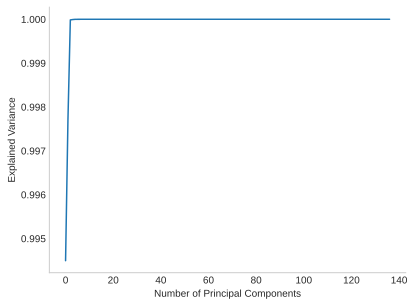

In [191]:
# Separate the dependent variable and indepedent variables

ord_target = "ORDINAL_" + target

Y = new_features_2[ord_target]

X = new_features_2.drop(columns=ord_target)


# Robust Scaling de X

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

transformer = RobustScaler()
transformer.set_output(transform="pandas")
transformer.fit(X)
X_scaled = transformer.transform(X)
X_scaled

# PCA pour réduire la dimension

pca = PCA()
pca.set_output(transform="pandas")
comp = pca.fit(X_scaled)

plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine()

pca = PCA(n_components=15).fit(X_scaled)
X_transformed = pca.transform(X_scaled)

X_transformed = pd.DataFrame(X_transformed)

X_transformed.to_csv("./data/preprocessed_afterPCA_Robust_X_train_10k.csv")


# # Add the intercept term
# X_transformed = sm.add_constant(X_transformed)

# # splitting the data in 70:30 ratio of train to test data
# X_train, X_test, y_train, y_test = train_test_split(X_transformed, Y, test_size = 0.30, random_state=42)

In [187]:
b = pd.DataFrame(Y)

for col in b.columns:
    b[col] = b[col].astype("int")
b

,ORDINAL_piezo_groundwater_level_category
2613083,0
1268326,0
234393,1
1670802,0
2804886,4
...,...
28346,0
1678943,2
1784633,0
813048,1


In [189]:
# UMAP pour réduire la dimension

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_scaled)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in b[ord_target].map({"0": int(0), 
                                                "1":int(1), 
                                                "2":int(2),
                                                "3":int(3),
                                                "4":int(4),
                                                })])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

TypeError: list indices must be integers or slices, not float

In [167]:
X_train

,const,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
8759,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314168e+06,-3.975249e+06,-9.088059e+04,-5.871943e+05,-4.811503e+05,-336882.530922,-4.371039,-4.553660,-1.133375,-1.075736,-0.736994,-1.110912
1434,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088155e+04,-5.871937e+05,-4.811519e+05,-336883.283114,-2.463860,-4.776812,-1.625294,0.556885,-1.158473,2.950450
7320,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314172e+06,-3.975252e+06,-9.088248e+04,-5.871942e+05,-4.811497e+05,-336883.059724,33.180902,-9.361812,-1.953619,0.107227,-0.729832,-0.045843
2579,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975253e+06,-9.087955e+04,-5.871939e+05,-4.811508e+05,-336882.420809,-4.210935,-3.484724,-1.057278,-1.124951,0.505968,4.200812
9142,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314169e+06,-3.975250e+06,-9.088114e+04,-5.871939e+05,-4.811511e+05,-336882.674060,-3.857862,-3.552407,-0.234276,-1.294190,3.891449,12.037322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975253e+06,-9.088104e+04,-5.871938e+05,-4.811517e+05,-336882.830402,30.174079,-8.688152,7.722819,0.529727,-0.194159,-1.265730
5191,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088006e+04,-5.871939e+05,-4.811521e+05,-336882.373919,-5.021783,-4.027551,-1.254096,-1.068612,-0.972830,-1.335064
5390,1.0,1.328166e+10,-5.558767e+09,4.715286e+09,-2.721049e+08,3.427956e+08,7.297379e+07,4.342810e+07,-2.545882e+07,413290.419189,-0.040518,-5.034256,-1.372499,-1.585122,2.244108,0.887486
860,1.0,-6.976061e+08,1.839296e+10,-8.180392e+08,-4.315895e+06,2.447661e+06,5.039695e+06,-1.442340e+06,2.104156e+06,196314.766969,-2.459133,-1.248535,-2.109921,-0.062743,-0.969067,-1.105090


In [153]:
X_test

,const,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2513,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088105e+04,-5.871940e+05,-4.811506e+05,-336882.579881,-5.105995,-4.440249,-1.649034,-0.743987,-0.284270,-1.325442
9411,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088078e+04,-5.871933e+05,-4.811525e+05,-336883.290439,33.515910,-9.261174,-0.628601,1.044706,-1.162055,-1.050878
8745,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314169e+06,-3.975249e+06,-9.088107e+04,-5.871941e+05,-4.811505e+05,-336882.834375,12.284053,-6.657621,-1.429244,-0.178444,-0.252140,-1.016970
9085,1.0,-1.150915e+09,1.581052e+10,-7.225525e+08,-2.836511e+06,1.920821e+06,4.726052e+06,-1.288480e+06,1.944695e+06,83105.644644,-3.006780,-2.248857,-0.146864,1.034753,-1.246094,-1.025847
4950,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088184e+04,-5.871938e+05,-4.811511e+05,-336883.045661,-5.217476,-4.451613,-1.671162,0.095005,-1.444885,-1.131533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,1.0,-1.150911e+09,1.581650e+10,-7.227832e+08,-2.836378e+06,1.922458e+06,4.727390e+06,-1.288675e+06,1.945368e+06,83222.224539,27.737421,-6.082859,-1.199434,1.326698,-1.308922,-0.992735
4694,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314168e+06,-3.975249e+06,-9.088206e+04,-5.871932e+05,-4.811521e+05,-336883.492584,-4.322496,-4.495846,-1.425516,1.044200,-1.045355,-0.463587
1407,1.0,-1.148201e+09,1.996521e+10,-8.827700e+08,-2.744367e+06,3.058206e+06,5.655268e+06,-1.423763e+06,2.412653e+06,164124.324457,-2.989190,-1.507890,-1.904030,0.696943,-0.382364,-1.169314
535,1.0,-1.164985e+09,-5.726900e+09,1.079961e+08,-3.314171e+06,-3.975252e+06,-9.088045e+04,-5.871942e+05,-4.811505e+05,-336882.360350,-5.118662,-3.882713,-1.304140,-1.422353,-0.677058,0.023032


## Feature Engineering & Selection

### VIF

In [140]:
vif = checking_vif(X_train)
vif

,feature,VIF
0,const,317.523070
1,piezo_station_investigation_depth,1.349110
2,piezo_station_altitude,4.482999
3,piezo_station_longitude,1753.161725
4,piezo_station_latitude,1367.954093
...,...,...
133,piezo_station_department_code_90,1.437472
134,piezo_station_department_code_91,2.978994
135,piezo_station_department_code_93,1.481055
136,piezo_station_department_code_95,1.824318


On vire les features VIF > 5

In [141]:
vif[vif["VIF"] < 5]

,feature,VIF
1,piezo_station_investigation_depth,1.349110
2,piezo_station_altitude,4.482999
5,piezo_producer_code,3.891758
8,meteo_altitude,4.581016
9,meteo_rain_height,1.027756
...,...,...
133,piezo_station_department_code_90,1.437472
134,piezo_station_department_code_91,2.978994
135,piezo_station_department_code_93,1.481055
136,piezo_station_department_code_95,1.824318


In [142]:
features_vif = vif[vif["VIF"] < 5]["feature"].to_numpy()

X_train_2 = X_train[features_vif]
X_test_2 = X_test[features_vif]
X_train_2

,piezo_station_investigation_depth,piezo_station_altitude,piezo_producer_code,meteo_altitude,meteo_rain_height,meteo_temperature_min,meteo_time_tn,meteo_temperature_max,meteo_evapotranspiration_grid,hydro_observation_result_elab,distance_piezo_hydro,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_%_ind,insee_%_const,ORDINAL_piezo_obtention_mode,ORDINAL_piezo_status,ORDINAL_piezo_measure_nature_code,ORDINAL_hydro_status_label,ORDINAL_hydro_qualification_code,piezo_station_department_code_03,piezo_station_department_code_04,piezo_station_department_code_05,piezo_station_department_code_06,piezo_station_department_code_07,piezo_station_department_code_08,piezo_station_department_code_09,piezo_station_department_code_10,piezo_station_department_code_12,piezo_station_department_code_13,piezo_station_department_code_15,piezo_station_department_code_18,piezo_station_department_code_19,piezo_station_department_code_21,piezo_station_department_code_22,piezo_station_department_code_23,piezo_station_department_code_25,piezo_station_department_code_30,piezo_station_department_code_31,piezo_station_department_code_32,piezo_station_department_code_38,piezo_station_department_code_39,piezo_station_department_code_42,piezo_station_department_code_43,piezo_station_department_code_46,piezo_station_department_code_48,piezo_station_department_code_51,piezo_station_department_code_52,piezo_station_department_code_53,piezo_station_department_code_54,piezo_station_department_code_55,piezo_station_department_code_58,piezo_station_department_code_61,piezo_station_department_code_63,piezo_station_department_code_64,piezo_station_department_code_65,piezo_station_department_code_69,piezo_station_department_code_70,piezo_station_department_code_71,piezo_station_department_code_73,piezo_station_department_code_74,piezo_station_department_code_75,piezo_station_department_code_78,piezo_station_department_code_81,piezo_station_department_code_82,piezo_station_department_code_83,piezo_station_department_code_84,piezo_station_department_code_87,piezo_station_department_code_88,piezo_station_department_code_89,piezo_station_department_code_90,piezo_station_department_code_91,piezo_station_department_code_93,piezo_station_department_code_95,hydro_hydro_quantity_elab_QmM
8573,-0.170629,1.173611,-1.120690e-01,1.10000,0.250000,-3.510638e-01,3.363071e+00,-0.707547,-0.555556,-0.205681,-0.333969,0.608706,0.250000,0.247380,-0.176471,1.614604,0.0,0.0,1.000000,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766621,-0.457343,-0.493958,2.909483e-02,-0.50000,4.062500,2.659574e-01,-1.369295e-01,1.160377,0.703704,-0.195251,-0.032261,2.561342,1.612069,-0.223115,-0.390374,0.308316,0.0,0.0,1.000000,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2773464,0.030769,0.159722,-6.465517e-03,2.98125,1.125000,3.085106e-01,-8.589212e-01,0.339623,0.518519,-0.205264,-0.951988,38.476701,0.931034,-0.342551,-0.390374,-0.300203,0.0,0.0,0.000000,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970406,0.618182,-0.348681,2.909483e-02,-0.57500,5.625000,-2.446809e-01,-1.068465e+00,-0.566038,-0.481481,0.845392,0.233358,0.667137,-0.301724,0.380997,1.331551,0.081136,0.0,0.0,0.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999664,3.544484,1.927083,-1.088362e-01,2.60625,1

In [143]:
X_test_2

,piezo_station_investigation_depth,piezo_station_altitude,piezo_producer_code,meteo_altitude,meteo_rain_height,meteo_temperature_min,meteo_time_tn,meteo_temperature_max,meteo_evapotranspiration_grid,hydro_observation_result_elab,distance_piezo_hydro,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_%_ind,insee_%_const,ORDINAL_piezo_obtention_mode,ORDINAL_piezo_status,ORDINAL_piezo_measure_nature_code,ORDINAL_hydro_status_label,ORDINAL_hydro_qualification_code,piezo_station_department_code_03,piezo_station_department_code_04,piezo_station_department_code_05,piezo_station_department_code_06,piezo_station_department_code_07,piezo_station_department_code_08,piezo_station_department_code_09,piezo_station_department_code_10,piezo_station_department_code_12,piezo_station_department_code_13,piezo_station_department_code_15,piezo_station_department_code_18,piezo_station_department_code_19,piezo_station_department_code_21,piezo_station_department_code_22,piezo_station_department_code_23,piezo_station_department_code_25,piezo_station_department_code_30,piezo_station_department_code_31,piezo_station_department_code_32,piezo_station_department_code_38,piezo_station_department_code_39,piezo_station_department_code_42,piezo_station_department_code_43,piezo_station_department_code_46,piezo_station_department_code_48,piezo_station_department_code_51,piezo_station_department_code_52,piezo_station_department_code_53,piezo_station_department_code_54,piezo_station_department_code_55,piezo_station_department_code_58,piezo_station_department_code_61,piezo_station_department_code_63,piezo_station_department_code_64,piezo_station_department_code_65,piezo_station_department_code_69,piezo_station_department_code_70,piezo_station_department_code_71,piezo_station_department_code_73,piezo_station_department_code_74,piezo_station_department_code_75,piezo_station_department_code_78,piezo_station_department_code_81,piezo_station_department_code_82,piezo_station_department_code_83,piezo_station_department_code_84,piezo_station_department_code_87,piezo_station_department_code_88,piezo_station_department_code_89,piezo_station_department_code_90,piezo_station_department_code_91,piezo_station_department_code_93,piezo_station_department_code_95,hydro_hydro_quantity_elab_QmM
1720536,0.338462,0.319444,2.909483e-02,-0.39375,0.000,0.063830,-0.195021,-0.622642,-0.481481,-0.167994,-0.113558,-0.112012,-0.301724,-0.290554,-0.235294,-0.170385,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2758629,-0.139161,-0.412500,2.909483e-02,-0.54375,0.000,0.457447,-0.139004,0.971698,1.481481,-0.116260,1.261260,38.808236,-0.258621,0.958639,-0.262032,-0.154158,0.0,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2629309,0.520280,0.666667,-1.099138e-01,0.46875,0.250,-0.127660,3.304979,-0.047170,-0.111111,-0.187463,-0.535298,17.404927,-0.215517,0.036871,-0.224599,2.141988,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506780,-0.402797,-0.731458,2.155343e+10,-0.65625,0.000,1.500000,-0.145228,1.084906,0.814815,-0.011125,0.037898,0.275836,-0.267241,1.529662,-0.363636,-0.348884,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1311378,-0.529634,-0.570833,-9.698276e-03,-0.60625,0.000,0.414894,-0.763485,0.415094,0.296296,-0.194277,

## Predictive Modeling

### XGBoost multiclass classifier

#### Test naïf rapide

In [107]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [154]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.2612330198537095

#### GridSearch CV

In [120]:
from scipy.stats import uniform, randint

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [145]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}


search = RandomizedSearchCV(xgb_model, 
                            param_distributions=params, 
                            random_state=42, 
                            n_iter=100, 
                            cv=2, 
                            verbose=1, 
                            n_jobs=1, 
                            return_train_score=True)

search.fit(X_train_2, y_train)




Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f31d627fcd0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f31c499f820>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f31d627fa90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f31c89d8c70>},
                   random_state=42, return_train_score=True, verbose=1)

In [146]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.330 (std: 0.007)
Parameters: {'colsample_bytree': 0.9078671076075817, 'gamma': 0.17416830222659868, 'learning_rate': 0.3109944455567122, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.7671784126862315}

